# Importing Data

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
import zipfile

with zipfile.ZipFile("titanic.zip", 'r') as zip_ref:
    zip_ref.extractall("titanic_data")

Saving kaggle.json to kaggle.json
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 133MB/s]


# Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib
matplotlib.style.use('seaborn-v0_8')

In [3]:
df = pd.read_csv('./titanic_data/train.csv')

In [4]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df.describe()

/tmp/ipython-input-927972377.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 1.0, 'Women and children first !')

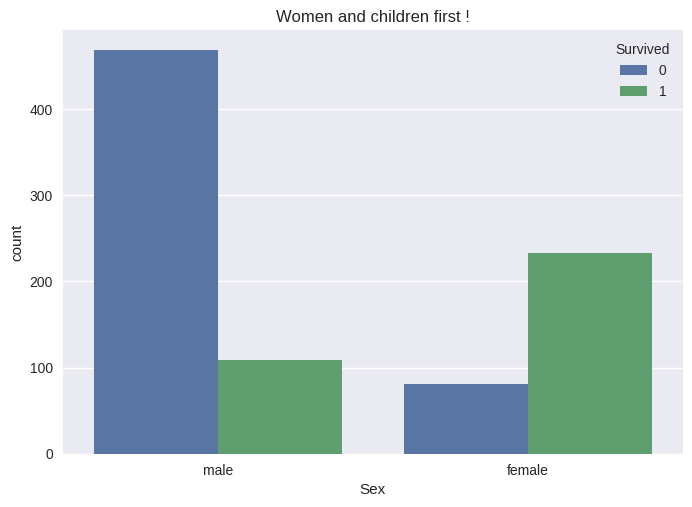

In [5]:
sns.countplot(x= 'Sex', hue='Survived', data=df)
plt.title("Women and children first !")

Text(0.5, 1.0, 'Women and children first !')

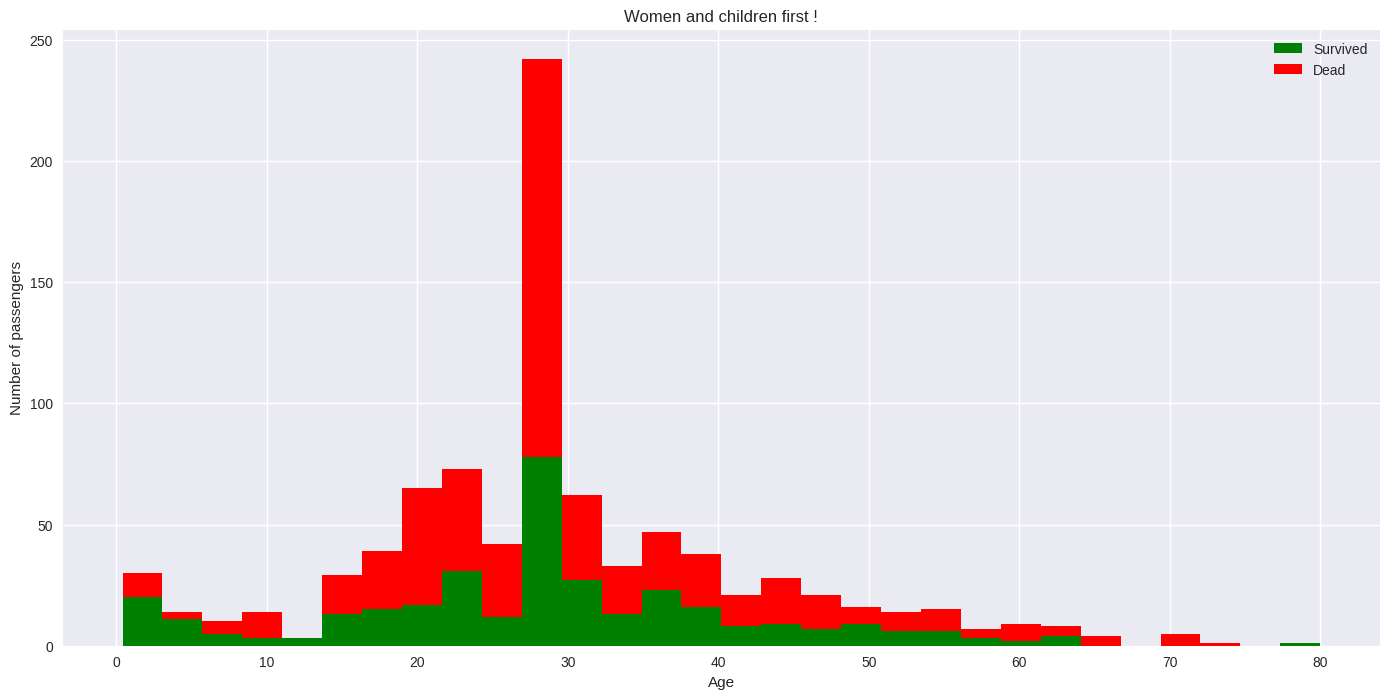

In [6]:
figure = plt.figure(figsize=(17,8))
plt.hist([df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30, label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.title("Women and children first !")

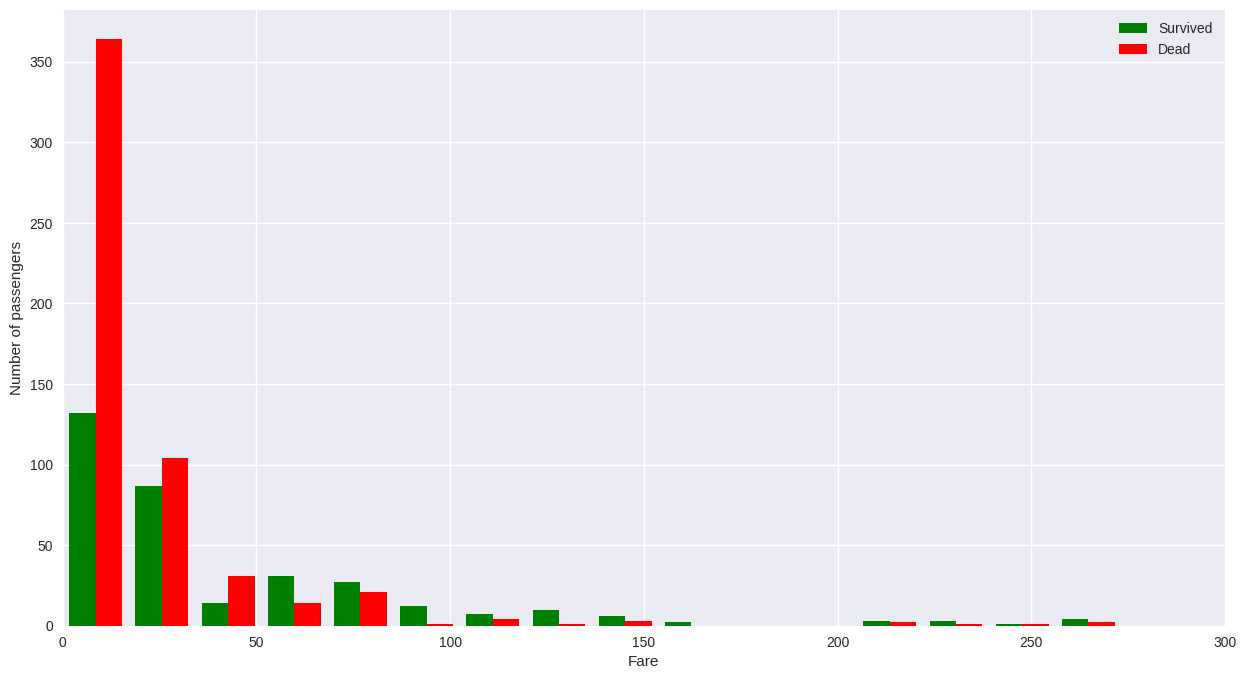

In [7]:
figure = plt.figure(figsize=(15,8))
plt.hist([df[df['Survived']==1]['Fare'],
          df[df['Survived']==0]['Fare']], color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.xlim([0,300])
plt.ylabel('Number of passengers')
plt.legend()

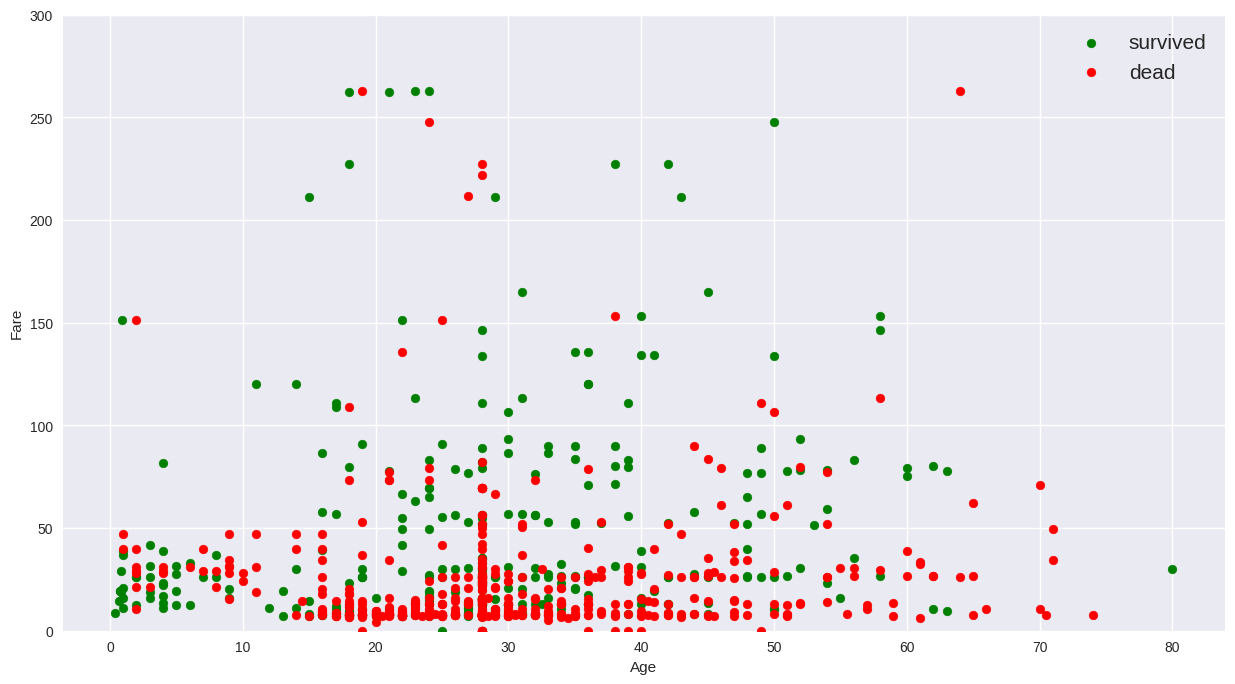

In [8]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(df[df['Survived']==1]['Age'],df[df['Survived']==1]['Fare'], c='green',s=40)
ax.scatter(df[df['Survived']==0]['Age'],df[df['Survived']==0]['Fare'], c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_ylim([0,300])
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

<Axes: xlabel='Embarked', ylabel='count'>

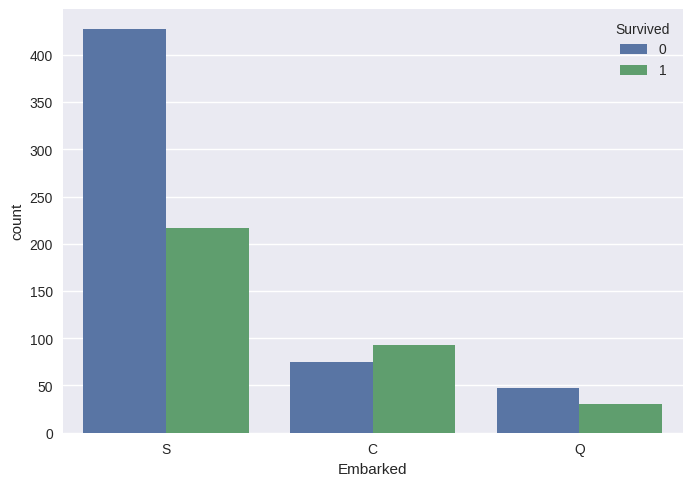

In [9]:
sns.countplot(x= 'Embarked', hue='Survived', data=df)

# Feature Engineering

In [11]:
train = pd.read_csv('./titanic_data/train.csv')
test = pd.read_csv('./titanic_data/test.csv')
targets = train.Survived
train.drop('Survived', axis=1, inplace=True)
combined = pd.concat([train, test], ignore_index=True)
combined.reset_index(inplace=True)
combined.drop('index', inplace=True, axis=1)

In [12]:
Title_Dictionary = {"Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Lady" :      "Royalty"}
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined['Title'] = combined.Title.apply(lambda x:Title_Dictionary.get(x,x))

In [13]:
grouped_median_train = combined.iloc[:len(train)].groupby(['Sex', 'Pclass', 'Title']).median(numeric_only=True)
grouped_median_test = combined.iloc[len(train):].groupby(['Sex', 'Pclass', 'Title']).median(numeric_only=True)

In [14]:
def fillAges(row, grouped_median):
    if np.isnan(row['Age']):
        return grouped_median.loc[row['Sex'], row['Pclass'], row['Title']]['Age']
    else:
        return row['Age']

In [15]:
combined.iloc[:len(train)]['Age'] = combined.iloc[:len(train)].apply(lambda r : fillAges(r, grouped_median_train), axis=1)
combined.iloc[len(train):]['Age'] = combined.iloc[len(train):].apply(lambda r : fillAges(r, grouped_median_test), axis=1)

/tmp/ipython-input-3486088688.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  combined.iloc[:len(train)]['Age'] = combined.iloc[:len(train)].apply(lambda r : fillAges(r, grouped_median_train), axis=1)
/tmp/ipython-input-3486088688.py:1: 

In [16]:
combined.drop('Name', axis=1, inplace=True)
le_title = LabelEncoder()
combined['Title'] = le_title.fit_transform(combined['Title'])

In [17]:
# Fills the fare by the mean
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

# Fills the embarked by the most common
combined.Embarked.fillna('S', inplace=True)

le_embarked = LabelEncoder()
combined['Embarked'] = le_embarked.fit_transform(combined['Embarked'])

# Replacing missing cabins with U (for Unknown)
combined.Cabin.fillna('U', inplace=True)
# mapping each Cabin value with the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])

le_cabin = LabelEncoder()
combined['Cabin'] = le_cabin.fit_transform(combined['Cabin'])

# Encoder for Sex
le_sex = LabelEncoder()
combined['Sex'] = le_sex.fit_transform(combined['Sex'])

/tmp/ipython-input-773104864.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined.Fare.fillna(combined.Fare.mean(), inplace=True)
/tmp/ipython-input-773104864.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [18]:
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = list(map(lambda t : t.strip(), ticket))
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'

In [19]:
combined['Ticket'] = combined['Ticket'].apply(cleanTicket)
le_ticket = LabelEncoder()
combined['Ticket'] = le_ticket.fit_transform(combined['Ticket'])

In [20]:
# Variables around family feature
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5<=s else 0)

combined.drop('PassengerId', inplace=True, axis=1)

# Modeling

In [21]:
X_train = combined.head(len(train))
X_test = combined[len(train):]
y_train = df.Survived

In [22]:
def compute_score(clf, X, y, scoring='accuracy'):
  xval = cross_val_score(clf, X, y, cv=5, scoring=scoring)
  return np.mean(xval)

In [23]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [24]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
test_reduced = model.transform(X_test)
train_reduced.shape, X_train.shape

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((891, 4), (891, 14))

In [25]:
parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6
              }
model = RandomForestClassifier(**parameters)
model.fit(train_reduced, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50)

In [26]:
compute_score(model, train_reduced, y_train, scoring='accuracy')

np.float64(0.7979662293641329)

In [28]:
output = model.predict(test_reduced).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./titanic_data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId', 'Survived']].to_csv('.output.csv', index=False)

In [29]:
model.score(train_reduced, y_train)

0.8484848484848485